# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [2]:
# !pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# add any additional libaries you need here
import nltk
nltk.download('brown')
import matplotlib
from gensim.models import LdaModel
from gensim import matutils, corpora
import gensim

%matplotlib inline


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resource

In [4]:
# !pip uninstall matplotlib
# !pip install matplotlib

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

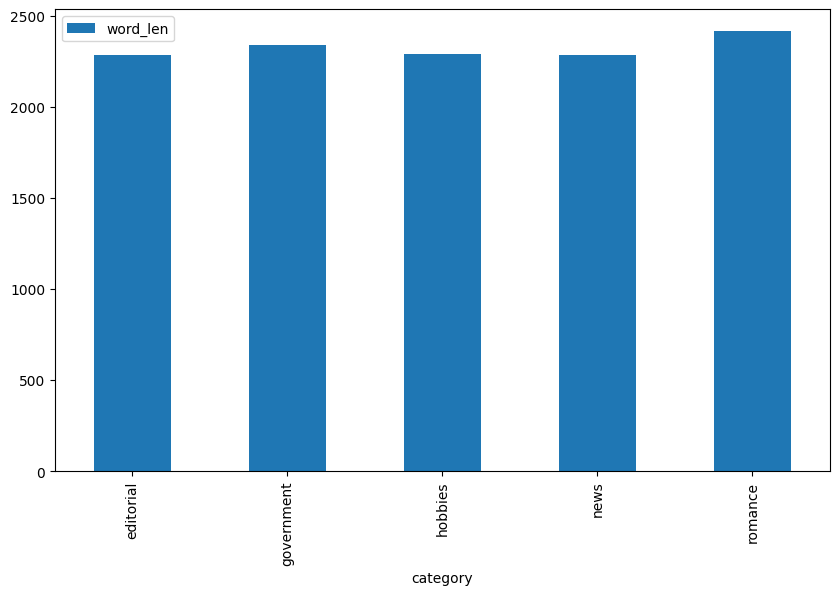

In [9]:
# %matplotlib inline

df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The 'count_text_vectors' and 'tfidf_text_vectors' hold the transformed representations of the text data from the TF-IDF and count vectorization techniques. They allow the applications of machine learning algorithms for running topic modeling and other text based analysis.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [14]:
# Your code here

topic_to_category = defaultdict(list)

for idx, row in enumerate(W_text_matrix):
    topic = np.where(row == np.amax(row))[0][0]
    category = df["category"].iloc[idx]
    topic_to_category[topic].append(category)

for topic, categories in topic_to_category.items():
    topic_name = f"Topic {topic}"
    category_counts = Counter(categories)
    total_count = sum(category_counts.values())
    print(f"\n{topic_name}:")
    for category, count in category_counts.items():
        percentage = (count / total_count) * 100
        print(f"Category: {category}, Count: {count}, Percentage: {percentage:.2f}%")


Topic 2:
Category: editorial, Count: 2, Percentage: 3.08%
Category: government, Count: 26, Percentage: 40.00%
Category: news, Count: 11, Percentage: 16.92%
Category: hobbies, Count: 26, Percentage: 40.00%

Topic 0:
Category: editorial, Count: 20, Percentage: 62.50%
Category: government, Count: 4, Percentage: 12.50%
Category: news, Count: 8, Percentage: 25.00%

Topic 1:
Category: editorial, Count: 4, Percentage: 9.76%
Category: romance, Count: 29, Percentage: 70.73%
Category: hobbies, Count: 8, Percentage: 19.51%

Topic 4:
Category: editorial, Count: 1, Percentage: 10.00%
Category: news, Count: 8, Percentage: 80.00%
Category: hobbies, Count: 1, Percentage: 10.00%

Topic 3:
Category: news, Count: 17, Percentage: 94.44%
Category: hobbies, Count: 1, Percentage: 5.56%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Other than topic 1, I don't see romance in any of these topics. Topic 2 has 4/5 categories and the other topics have either 3/5 or 2/5 topics. News is in 4/5 topics and is a staggering 94.44% in topic 3.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [15]:
# Your code here

lsa_model = TruncatedSVD(n_components=5, random_state=6102023)
lsa_text_matrix = lsa_model.fit_transform(tfidf_text_vectors)

topic_to_category = defaultdict(list)

for idx, row in enumerate(lsa_text_matrix):
    topic = np.argmax(row)
    category = df["category"].iloc[idx]
    topic_to_category[topic].append(category)

for topic, categories in topic_to_category.items():
    topic_name = f"Topic {topic}"
    category_counts = Counter(categories)
    total_count = sum(category_counts.values())
    print(f"\n{topic_name}:")
    for category, count in category_counts.items():
        percentage = (count / total_count) * 100
        print(f"Category: {category}, Count: {count}, Percentage: {percentage:.2f}%")


Topic 0:
Category: editorial, Count: 27, Percentage: 18.24%
Category: government, Count: 30, Percentage: 20.27%
Category: news, Count: 34, Percentage: 22.97%
Category: romance, Count: 21, Percentage: 14.19%
Category: hobbies, Count: 36, Percentage: 24.32%

Topic 4:
Category: news, Count: 7, Percentage: 100.00%

Topic 3:
Category: news, Count: 3, Percentage: 100.00%

Topic 1:
Category: romance, Count: 8, Percentage: 100.00%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: topic 0 is hits all 5 categories and has a pretty similar coount in each category. The other topics only have one category either news or romance. 

In [16]:
# call display_topics on your model

display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.11)
  mr (1.70)
  said (1.03)
  kennedy (0.79)
  laos (0.77)

Topic 03
  mrs (30.33)
  club (6.71)
  game (6.25)
  jr (5.82)
  dallas (5.27)

Topic 04
  game (4.38)
  league (3.14)
  baseball (3.11)
  ball (2.99)
  team (2.86)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output? 

A: Starting from the bottom topic 3 and 4 seem to be related to sports games. Topic 4 especially talks about a baseball game. Topic 00,01,02 all have said which could relate to a conversation. Topic 02 is related to news it has the words kennedy and laos. It could be related to politics since well-known family Kennedy is there.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [17]:
# Fit your LDA model here

lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=6102023)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
for idx, row in enumerate(W_lda_para_matrix):
    topic = np.argmax(row)
    category = df["category"].iloc[idx]
    topic_to_category[topic].append(category)

for topic, categories in topic_to_category.items():
    topic_name = f"Topic {topic}"
    category_counts = Counter(categories)
    total_count = sum(category_counts.values())
    print(f"\n{topic_name}:")
    for category, count in category_counts.items():
        percentage = (count / total_count) * 100
        print(f"Category: {category}, Count: {count}, Percentage: {percentage:.2f}%")


Topic 0:
Category: editorial, Count: 31, Percentage: 17.42%
Category: government, Count: 35, Percentage: 19.66%
Category: news, Count: 50, Percentage: 28.09%
Category: romance, Count: 21, Percentage: 11.80%
Category: hobbies, Count: 41, Percentage: 23.03%

Topic 4:
Category: news, Count: 12, Percentage: 23.08%
Category: editorial, Count: 14, Percentage: 26.92%
Category: government, Count: 19, Percentage: 36.54%
Category: hobbies, Count: 7, Percentage: 13.46%

Topic 3:
Category: news, Count: 25, Percentage: 36.76%
Category: editorial, Count: 8, Percentage: 11.76%
Category: romance, Count: 29, Percentage: 42.65%
Category: hobbies, Count: 6, Percentage: 8.82%

Topic 1:
Category: romance, Count: 8, Percentage: 29.63%
Category: government, Count: 2, Percentage: 7.41%
Category: news, Count: 1, Percentage: 3.70%
Category: hobbies, Count: 16, Percentage: 59.26%

Topic 2:
Category: editorial, Count: 1, Percentage: 14.29%
Category: government, Count: 4, Percentage: 57.14%
Category: hobbies, Cou

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Call `display_topics` on your fitted model here

display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  state (1.41)
  said (0.85)
  mr (0.67)
  president (0.63)
  000 (0.53)

Topic 01
  feed (0.55)
  medical (0.54)
  use (0.50)
  fiscal (0.47)
  clay (0.44)

Topic 02
  shelter (0.84)
  business (0.83)
  small (0.82)
  brown (0.76)
  mr (0.54)

Topic 03
  said (1.29)
  mrs (0.68)
  old (0.49)
  man (0.48)
  little (0.42)

Topic 04
  united (0.73)
  states (0.58)
  government (0.52)
  development (0.50)
  american (0.47)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: Topic 00 seems to be related to state or government affairs, topic 01 is relate to someone named clay and he seems to have some medical issues, topic 02 has a small business theme, topic 03 is related to conversations between perhaps old man and his mrs, and last but not least topic 04 is related to the united states government and people. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 has 5/5 original categories. The rest of the topics have mostly 4/5 categories and only 1 with 3/5 categories. This model captures the overall number of categories better than the rest of the models that we used.

In [20]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Topic 3 has the lowest marginal topic distribution wheras topic 4 has the largest marginal topic distribution. Topic 3 salient words seems to be related to war or some sort of nuclear crisis. There are top salient words such as radiation, nuclear, fallout, missile, weapons, tests, aircraft, brown, and shelter. Topic 4 has the most popular sailent word said there is a conversation going on, there are old and young people, and words seem to be related to people living at home and leaving the home. Topic 1 and 5 seem to be related to politics and government. Lastly, topic 2 seems to be related to a bill or tax policy. 
